# 1. Gaussian kernel density estimation

## Kernel density estimator
Let $\{X_1, \cdots, X_N \}$ be a set of independent realizations from an unknown continuous probability density function $f$ in a certain space $\mathcal{X} \subset \mathbb{R}$. A kernel density estimator for $f$ is defined as

$$
\begin{array}{cc}
\displaystyle \hat{f}(x; h) = \frac{1}{Nh}\sum_{i=1}^N{\kappa\left( \frac{x - X_i}{h}\right)}, & x \in \mathbb{R}
\tag{1.1}
\end{array}
$$

where the **kernel function** $\kappa$ is (usually) a symmetric density function in $\mathbb{R}$, $\kappa(-x) = \kappa(x)$. $h$ is a positive smoothing parameter called **bandwidth**. Larger values of $h$ produce smoother estimations, while lower values produce more sinuous ones. There is a bias-variance tradeoff when choosing $h$.

While both the kernel function and the bandwidth affect the performance of the density estimator, the latter is much more relevant. In practice, one usually just pick a Gaussian kernel and devotes greater effort to the choice of the smoothing parameter $h$.

## Gaussian kernel
The **Gaussian kernel density estimator** arises when $\kappa$ is the **pdf** of a standard normal distribution. Thus, the estimator is of the form

$$
 \begin{array}{cc}
  \displaystyle \hat{f}(x; h) = \frac{1}{Nh}\sum_{i=1}^N{\varphi\left( \frac{x - X_i}{h}\right)}, & x \in \mathbb{R}
 \end{array}
$$

where

$$
\displaystyle \varphi(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}
$$

Putting all the pieces together, the estimator results in

$$
 \hat{f}(x;h) = \frac{1}{Nh}\sum_{i=1}^N{\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x - X_i}{h}\right)^2}}
$$

which can be seen as the average of $N$ normal distributions centered at each of the $X_i$ with a common standard deviation $h$

$$
 \hat{f}(x;h) = \frac{1}{N}\sum_{i=1}^N{\frac{1}{\sqrt{2\pi}h}e^{-\frac{1}{2}\left(\frac{x - X_i}{h}\right)^2}}
 \tag{1.2}
$$

In practice, $x$ is just an equally spaced grid of values in an interval of the real line.

## Error measurement

A very popular criteria to assess the performance of an estimator $\hat{f}$ is the **Mean Integrated Squared Error**

$$
\text{MISE}(h) = \mathbb{E}_f\int{[\hat{f}(x; h) - f(x)]^2}dx
$$

which can be decomposed in the integrated squared bias and integrated variance

$$
\text{MISE}(h) = \int{(\underbrace{\mathbb{E}_f[\hat{f}(x; h)] - f(x)}_{\text{pointwise bias of } \hat{f}})^2}dx + 
\int{\underbrace{Var_f(\hat{f}(x; h))}_{\text{pointwise variance of } \hat{f}}}dx
$$

In the context of a Gaussian kernel, an asymptotic first-order approximation for the **MISE** is given by

$$
\frac{1}{4} h^4 \lVert f'' \rVert^2 + \frac{1}{2N\sqrt{\pi t}}
\tag{1.3}
$$

where $\lVert f'' \rVert^2 = \int(f''(x))^2dx$.

## *Optimal* bandwidth for the Gaussian KDE

It is possible to show the value of $h$ that minimizes (1.3) asymptotically is

$$
h^* = \left(\frac{1}{2N\sqrt{\pi} \lVert f'' \rVert^2} \right)^{1 / 5}
$$

We can observe the optimal $h^*$ in a Gaussian KDE requires $\lVert f'' \rVert^2$ for its calculation. However, it is an unknown quantity because $f$ is unknown. 

A frequently used **Gaussian rule of thumb** is obtained assuming that $f$ is the density of a random variable following a $\mathcal{N}(\hat{\mu}, \hat{\sigma}^2)$. In this scenario, $\lVert f''\rVert^2 = \hat{\sigma}^{-5}\pi^{-1/2}3/8$, and then the rule suggests

$$
h_{rot} = \left(\frac{4\hat{\sigma}^5}{3N} \right)^{1/5} \approx 1.058N^{0.2}\hat{\sigma}
$$

A more robust rule of thumb has been proposed to mitigate the effect of possible outliers and/or more serious deviations from normality

$$
h_{Rot} = \left(\frac{4S^5}{3N} \right)^{1/5}
$$

where $S = \min\{\hat{\sigma}, \frac{R}{1.34}\}$ is a robust measure of the dispersion in the observations. $R$ represents the inter-quartile range, defined as

$$
R = \underbrace{X_{([0.75N])}}_{\text{75% quantile}} - \underbrace{X_{([0.25N])}}_{\text{25% quantile}}
$$

### **Remarks**

1. We start using a non-parametric method to estimate a density because we want to avoid the rigid structure imposed by assuming that our sample comes from a particular pre-specified distribution. We end up assuming a normal distribution to obtain a plausible rule for $h$. 
2. Gaussian rule of thumb and robust gaussian rule of thumb can be found in Silverman, B. W. 1998, *Density Estimation for Statistics and Data Analysis*. Monographs on Statistics and Applied Probability. Chapman & Hall/CRC.
3. The computational complexity of (1.1) is $O(n^2)$.

## Naive (but straight) implementation of Gaussian KDE

In [3]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]

def gaussian_kde(x, h=None):
    
    """
    Naive, inefficient, but straightforward Gaussian KDE
    
    Parameters
    ----------
    x : array-like
        1 dimensional array of the variable for which a 
        density estimate is desired.
    h : float, optional
        Bandwidth (standard deviation of each Gaussian component)
        Defaults to None, which uses gaussian rule of thumb.
    
    Returns
    -------
    grid : Gridded numpy array for the x values.
    pdf : Numpy array for the density estimates.
    
    """
    
    x_std = np.std(x)
    x_len = len(x)
    
    grid_len = 1000
    grid_min = np.min(x) - 1 * x_std
    grid_max = np.max(x) + 1 * x_std
    
    grid = np.linspace(grid_min, grid_max, num=grid_len)
    
    pdf_mat = np.zeros((x_len, grid_len))
    
    if h is None:
        s = min(x_std, stats.iqr(x) / 1.34)
        h = 1.058 * s * x_len ** (-0.2)    
    
    for i in range(0, x_len):
        mu = x[i]
        pdf_mat[i, :] = np.exp(-0.5 * ((grid - mu) / h) ** 2) / (np.sqrt(2 * np.pi) * h)
     
    pdf = np.mean(pdf_mat, axis=0)
    
    return grid, pdf        

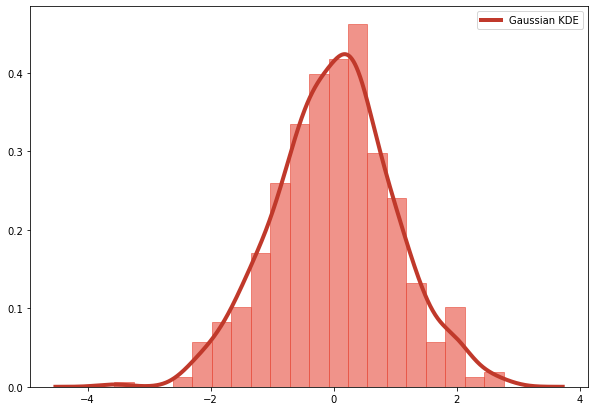

In [4]:
POMENGRATE = "#c0392b"
ALIZARIN = "#e74c3c"

np.random.seed(1234)

rvs = np.random.normal(size=500)
xval, yval = gaussian_kde(rvs)

plt.plot(xval, yval, linewidth=4,
         color=POMENGRATE, label="Gaussian KDE")
plt.hist(rvs, density=True, bins=20,
         alpha=0.6, Color=ALIZARIN)
plt.legend()
plt.show()

# 2. Faster implementations of the Gaussian KDE
## a. Convolution of the sample empirical distribution with a Gaussian density

The source of this section is obtained from [this answer](https://stats.stackexchange.com/questions/73623/kernel-density-estimation-is-a-convolution-of-what) in Stack Overflow

Let $\{x_1, \cdots, x_N \}$ be a set of sample observations. Their sample empirical density can be written as 

$$
f_x(x) = \frac{1}{N} \sum_{i=1}^{N}{\delta(x - x_i)}
$$

Where $\delta$ is a "generalized function". Despite that name, it is not a function at all: it's a new mathematical object that can be used only within integrals. Its defining property is taht for any function $g$ of compact support that is continuous in a neighborhood of $0$,

$$
\int_{\mathbb{R}}{\delta(x)g(x)dx = g(0)}
\tag{2.1}
$$

The "function" $\delta$ is sometimes known as the [Dirac delta function](https://en.wikipedia.org/wiki/Dirac_delta_function). In the following calculation this concept is extended to include functions $g$ which are continuous from one side only.

Justifying this characterization of $f_X$ is the observation that

$$
  \begin{split}
    \int_{-\infty}^{x}{f_X(y)dy} & = \int_{-\infty}^{x}{\frac{1}{N}\sum_{i=1}^{N}{\delta(y - x_i)dy}} \\
    & = \frac{1}{N}\sum_{i=1}^{N}{\int_{-\infty}^{x}{\delta(y - x_i)dy}} \\
    & = \frac{1}{N}\sum_{i=1}^{N}{\int_{\mathbb{R}}{I(y \le x)\delta(y - x_i)dy}} \\
    & = \frac{1}{N}\sum_{i=1}^{N}{I(x_i \le x)} \\
    & = F_X(x)
  \end{split}
$$

where $F_X$ is the empirical cumulative distribution function and $I$ is the indicator function.

In my opinion, the most tricky part of the previous demonstration is how to pass from row 3 to row 4. That step is supported by the defining property in (2.1) seeing that $g(x)$ is $I(y \le x)$.

The convolution of $f_X(x)$ with any other function $\kappa_h$ is given, by definition, as

$$
  \begin{split}
    (f_X * \kappa)(x) & = \int_{\mathbb{R}}{f_X(x-y)\kappa_h(y)dy} \\
    & = \int_{\mathbb{R}}{\frac{1}{N}\sum_{i=1}{N}{\delta(x - y - x_i)\kappa_h(y)dy}} \\
    & = \frac{1}{N} \sum_{i=1}^{N}{\int_{\mathbb{R}}\delta(x - y - x_i)\kappa_h(y)dy} \\
    & = \frac{1}{N} \sum_{i=1}^{N}{\kappa_h(x_i - x)} 
  \end{split}
$$

Remembering we required the kernel to be symmetric, $\kappa_h(x) = \kappa_h(-x)$, we see clearly that the kernel density estimation is a convolution between the empirical density and a kernel function.

$$
(f_X * \kappa)(x) = \frac{1}{N} \sum_{i=1}^{N}{\kappa_h(x - x_i)} = \frac{1}{Nh} \sum_{i=1}^{N}{\kappa\left(\frac{x - x_i}{h}\right)}
$$

### Why is it faster?

FFT convolution uses the principle that multiplication in the frequency domain corresponds to convolution in the time domain. The input signal is transformed into the frequency domain using the DFT, multiplied by the frequency response of the filter, and then transformed back into the time domain using the Inverse DFT.

This basic technique was known since the days of Fourier; however, no one really cared. This is because the time required to calculate the DFT was longer than the time to directly calculate the convolution.  

This changed in 1965 with the development of the Fast Fourier Transform (FFT). By using the FFT algorithm to calculate the DFT, convolution via the frequency domain can be faster than directly convolving the time domain signals. The final result is the same; only the number of calculations has been changed by a more efficient algorithm. For this reason, FFT convolution is also called high-speed convolution.

[source](https://www.dspguide.com/ch18/2.htm)

### Implementation of Convolution based Gaussian KDE

In [89]:
import scipy
from scipy.signal import gaussian, convolve

def convolution_kde(x, h=None, grid_len=None, extend=True):
    
    if grid_len is None:
        grid_len = 512
    elif grid_len > 1024:
        grid_len = 1024
    else:
        grid_len = 2 ** np.ceil(np.log2(grid_len))
    
    x_len = len(x)
    x_max = np.max(x)
    x_min = np.min(x)
    x_range = x_max - x_min
    x_std = np.std(x)
    
    if extend:
        grid_min = x_min - 1 * x_std
        grid_max = x_max + 1 * x_std
    else:
        grid_min = x_min
        grid_max = x_max

    grid = np.linspace(grid_min, grid_max, num=grid_len + 1)
    
    # Relative frequency per bin
    f, edges = np.histogram(x, bins=grid, density=True)
    
    if h is None:
        s = min(x_std, stats.iqr(x) / 1.34)
        h = 1.058 * s * x_len ** (-0.2) 
     
    kernel = gaussian(100, 65 * h)  # why do I need to multiply `h` to make it work????
    kernel /= kernel.sum()

    density = convolve(f, kernel, mode="same", method="fft") / sum(kernel)
    
    grid = np.linspace(grid_min, grid_max, num=grid_len)
    
    return grid, density, h
    

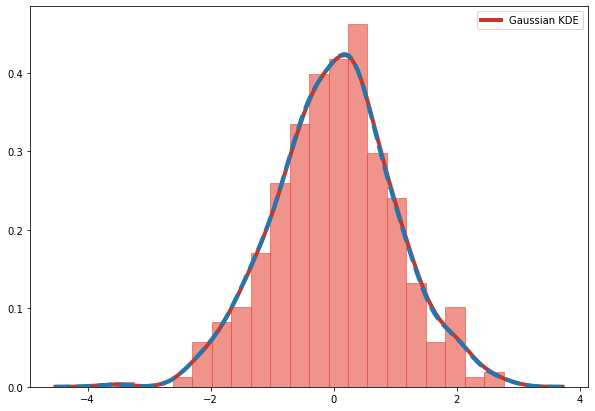

17.58558693677455


In [90]:
np.random.seed(1234)

rvs = np.random.normal(size=500)
xval, yval, bw = convolution_kde(rvs)

xval2, yval2 = gaussian_kde(rvs)

plt.plot(xval, yval, linewidth=4,
         color=POMENGRATE, label="Gaussian KDE")
plt.plot(xval2, yval2, linestyle="--", linewidth=4)
plt.hist(rvs, density=True, bins=20,
         alpha=0.6, Color=ALIZARIN)
plt.legend()
plt.show()

print(65*bw)

In [78]:
def _fast_kde(x, bw=4.5, xmin=None, xmax=None):

    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    
    if x.size == 0:
        warnings.warn("kde plot failed, you may want to check your data")
        return np.array([np.nan]), np.nan, np.nan

    len_x = len(x)
    n_points = 200 if (xmin or xmax) is None else 500

    if xmin is None:
        xmin = np.min(x)
    if xmax is None:
        xmax = np.max(x)

    log_len_x = np.log(len_x) * bw

    n_bins = min(int(len_x ** (1 / 3) * log_len_x * 2), n_points)
    if n_bins < 2:
        warnings.warn("kde plot failed, you may want to check your data")
        return np.array([np.nan]), np.nan, np.nan

    grid, _ = np.histogram(x, n_bins, range=(xmin, xmax), density=True)

    scotts_factor = len_x ** (-0.2)
    kern_nx = int(scotts_factor * 2 * np.pi * log_len_x)
    kernel = gaussian(kern_nx, scotts_factor * log_len_x)
    
    kernel /= kernel.sum()

    density = convolve(grid, kernel, mode="same", method="direct")

    return density, xmin, xmax, kern_nx, scotts_factor * log_len_x


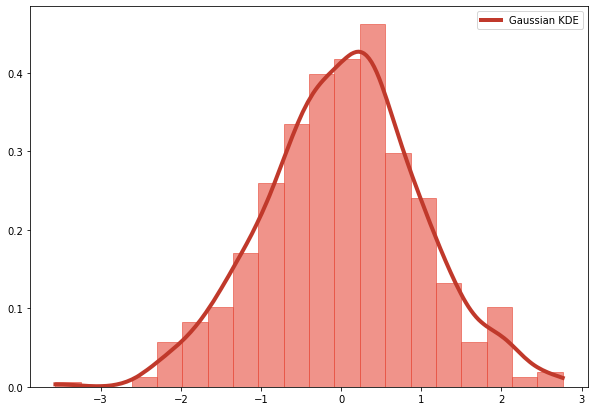

In [79]:
np.random.seed(1234)

rvs = np.random.normal(size=500)
yval, xmin, xmax, knx, bw = _fast_kde(rvs)

xval = np.linspace(xmin, xmax, num = len(yval))

plt.plot(xval, yval, linewidth=4,
         color=POMENGRATE, label="Gaussian KDE")
plt.hist(rvs, density=True, bins=20,
         alpha=0.6, Color=ALIZARIN)
plt.legend()
plt.show()

In [80]:
print(knx)
print(bw)

50
8.069233066959512
